# Import Data and Libraries

In [1]:
import kagglehub
import pandas as pd
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from sklearn.metrics import classification_report
from datasets import load_dataset

/home/david/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download latest version
kaggle_path = kagglehub.dataset_download("yashvrdnjain/hotdognothotdog")
ds = load_dataset("truepositive/hotdog_nothotdog")

print(f"Path to dataset files: {kaggle_path}")
print(f'Path to huggging_face files: {ds}')

Repo card metadata block was not found. Setting CardData to empty.
Generating validation split: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 11224.32 examples/s]

Path to dataset files: /home/david/.cache/kagglehub/datasets/yashvrdnjain/hotdognothotdog/versions/1
Path to huggging_face files: DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 200
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50
    })
})


In [4]:
print(ds.get('train'))

Dataset({
    features: ['image', 'label'],
    num_rows: 200
})


In [12]:
directory = f'{kaggle_path}/hotdog-nothotdog/train/'
test_directory = f'{kaggle_path}/hotdog-nothotdog/test/'

In [13]:
train_dataset = image_dataset_from_directory(directory, image_size=(224, 224), validation_split=.2, subset='training', batch_size = 32, seed=123)
validation_dataset = image_dataset_from_directory(directory, image_size=(224, 224), validation_split=.2, subset='validation', batch_size = 32, seed=123)
test_dataset = image_dataset_from_directory(test_directory, image_size=(224, 224), batch_size = 32)

Found 3000 files belonging to 2 classes.
Using 2400 files for training.
Found 3000 files belonging to 2 classes.
Using 600 files for validation.
Found 644 files belonging to 2 classes.


In [14]:
for data_batch, labels_batch in train_dataset:
    print('data batch  shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch  shape: (32, 224, 224, 3)
labels batch shape: (32,)


# Step 1: Initial Model Creation

In [15]:
def do_model(num_layers, start_filter, max_filter, dataset_train, dataset_val):
    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    num_filters = start_filter
    for _ in range(num_layers):
        x = layers.Conv2D(filters=num_filters, kernel_size=3, activation='relu', padding='same')(x)
        x = layers.MaxPooling2D(pool_size=2, padding='same')(x)
        num_filters = min(num_filters * 2, max_filter)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath='hotdog_convnet.keras.weights.h5',
            save_weights_only=True,
            monitor='val_loss',
            save_best_only=True
        )
    ]
    history = model.fit(
        dataset_train,
        epochs=30,
        validation_data=dataset_val,
        callbacks=callbacks)
    return model, history

In [16]:
def plot(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,073 (144.82 KB)

 Trainable params: 37,073 (144.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5168 - loss: 18.1041 - val_accuracy: 0.5067 - val_loss: 1.5313
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5782 - loss: 0.7933 - val_accuracy: 0.6183 - val_loss: 0.6656
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6333 - loss: 0.6716 - val_accuracy: 0.6200 - val_loss: 0.6762
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6965 - loss: 0.5914 - val_accuracy: 0.5917 - val_loss: 0.8412
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7439 - loss: 0.5280 - val_accuracy: 0.5950 - val_loss: 0.7362
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7868 - loss: 0.4801 - val_accuracy: 0.6450 - val_loss: 0.7150
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8301 - loss: 0.3806 - val_accuracy: 0.6600 - val_loss: 0.8018
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8731 - loss: 0.3437 - val_accuracy: 0.6617 - 

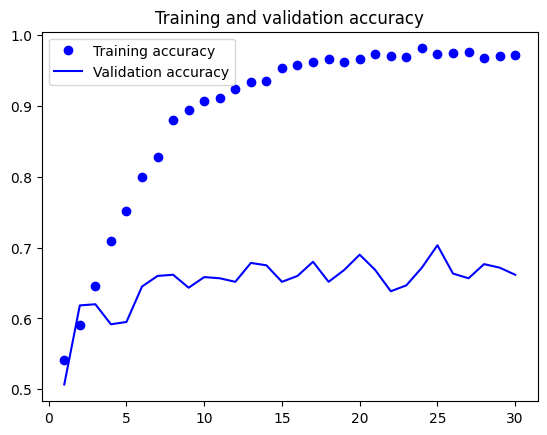

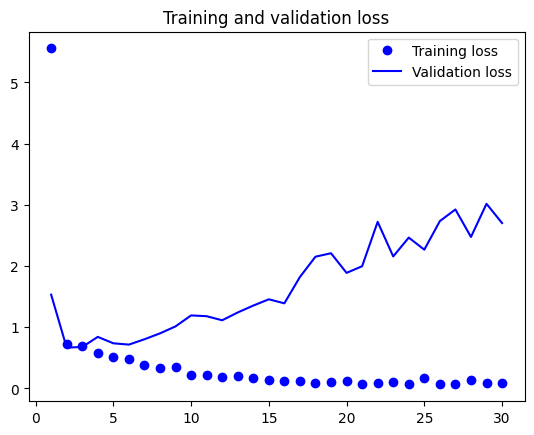


--- Classification Report for model ---
              precision    recall  f1-score   support

      hotdog     0.6038    0.5870    0.5953       322
   nothotdog     0.5982    0.6149    0.6064       322

    accuracy                         0.6009       644
   macro avg     0.6010    0.6009    0.6009       644
weighted avg     0.6010    0.6009    0.6009       644



2025-04-30 21:39:48.835292: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Train the model
model, history = do_model(4, 8, 64, train_dataset, validation_dataset)

# Plot training history
plot(history)

# Collect true labels and predictions
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset:
    preds = model.predict(x_batch, verbose=0)
    y_true.extend(y_batch.numpy())  # Ground truth labels
    y_pred.extend(np.round(preds).astype(int).flatten())  # Predicted labels

# Print classification report
print(f"\n--- Classification Report for model ---")
print(classification_report(y_true, y_pred, digits=4, target_names=test_dataset.class_names))
